<a href="https://colab.research.google.com/github/Ashritha0848/NLP/blob/main/2403A52229%2CAssignment_5_4%2CNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas nltk spacy matplotlib seaborn emoji
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
import pandas as pd
import re
import emoji
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter


In [4]:
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
df = pd.read_csv("/content/Tweets.csv")   # Kaggle file
df = df[['text', 'airline_sentiment']]
df.head()


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [6]:
tweets = df['text']


In [7]:
def clean_tweet(text):
    text = re.sub(r"http\S+", "", text)          # remove URLs
    text = re.sub(r"@\w+", "", text)              # remove mentions
    text = re.sub(r"#", "", text)                 # remove hashtag symbol
    text = emoji.replace_emoji(text, "")          # remove emojis
    text = re.sub(r"[^a-zA-Z\s]", "", text)       # remove special chars
    text = text.lower().strip()
    return text

df['clean_text'] = df['text'].apply(clean_tweet)
df[['text', 'clean_text']].head()


,text,clean_text
0,@VirginAmerica What @dhepburn said.,what said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...
2,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it


In [9]:
nltk.download('punkt_tab')
df['tokens'] = df['clean_text'].apply(word_tokenize)
df['tokens'].head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,tokens
0,"[what, said]"
1,"[plus, youve, added, commercials, to, the, exp..."
2,"[i, didnt, today, must, mean, i, need, to, tak..."
3,"[its, really, aggressive, to, blast, obnoxious..."
4,"[and, its, a, really, big, bad, thing, about, it]"


In [10]:
stop_words = set(stopwords.words('english'))

df['tokens_nostop'] = df['tokens'].apply(
    lambda x: [word for word in x if word not in stop_words]
)


In [12]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

df['lemmas'] = df['tokens_nostop'].apply(lemmatize_tokens)


In [13]:
df['final_text'] = df['lemmas'].apply(lambda x: " ".join(x))
df[['clean_text', 'final_text']].head()


,clean_text,final_text
0,what said,say
1,plus youve added commercials to the experience...,plus you ve add commercial experience tacky
2,i didnt today must mean i need to take another...,do not today must mean need take another trip
3,its really aggressive to blast obnoxious enter...,really aggressive blast obnoxious entertainmen...
4,and its a really big bad thing about it,really big bad thing


In [14]:
from spacy.language import Language

@Language.component("hashtag_detector")
def hashtag_detector(doc):
    doc._.hashtags = [token.text for token in doc if token.text.startswith("#")]
    return doc

# Register extension
from spacy.tokens import Doc
Doc.set_extension("hashtags", default=[])

# Add to pipeline
nlp.add_pipe("hashtag_detector", last=True)


<function __main__.hashtag_detector(doc)>

In [15]:
doc = nlp(df['final_text'][0])

for token in doc:
    print(token.text, token.lemma_, token.pos_)


say say VERB


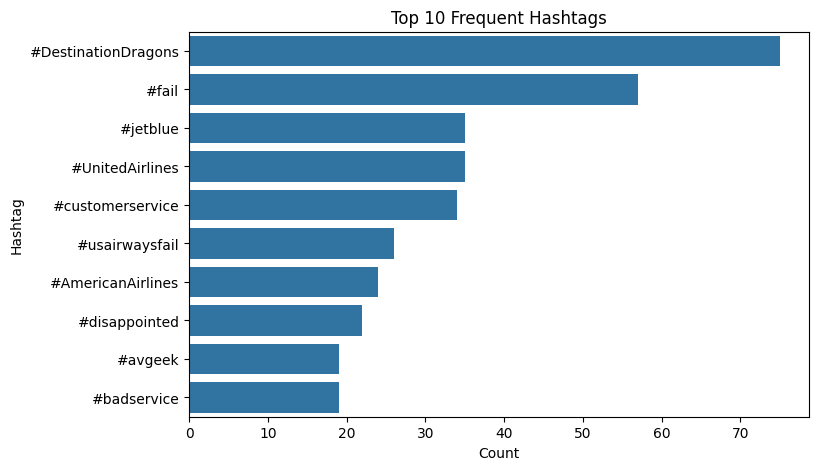

In [16]:
hashtags = []

for text in df['text']:
    hashtags.extend(re.findall(r"#\w+", text))

hashtag_freq = Counter(hashtags).most_common(10)

hashtags_df = pd.DataFrame(hashtag_freq, columns=["Hashtag", "Count"])

plt.figure(figsize=(8,5))
sns.barplot(x="Count", y="Hashtag", data=hashtags_df)
plt.title("Top 10 Frequent Hashtags")
plt.show()


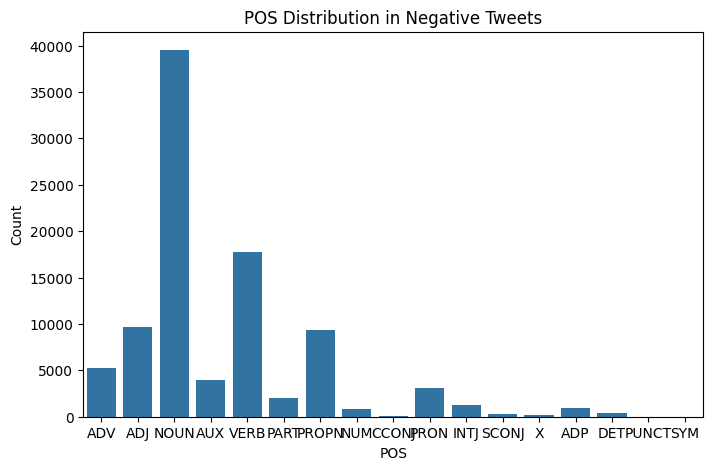

In [17]:
negative_tweets = df[df['airline_sentiment'] == 'negative']['final_text']

pos_tags = []

for tweet in negative_tweets:
    doc = nlp(tweet)
    pos_tags.extend([token.pos_ for token in doc])

pos_freq = Counter(pos_tags)

pos_df = pd.DataFrame(pos_freq.items(), columns=["POS", "Count"])

plt.figure(figsize=(8,5))
sns.barplot(x="POS", y="Count", data=pos_df)
plt.title("POS Distribution in Negative Tweets")
plt.show()
